In [1]:
using Distributions, Plots
default(leg=:none)

Generate some Poisson distributed test data

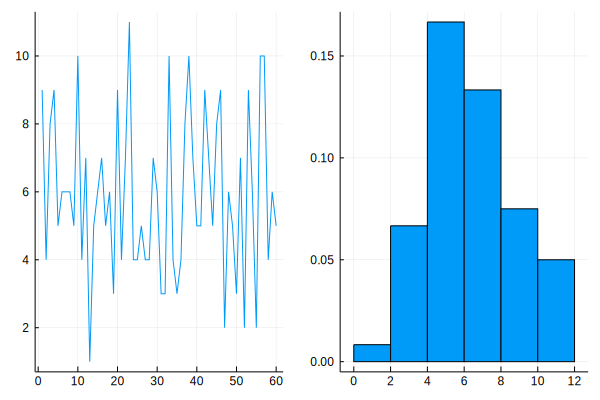

In [2]:
n=60 # the number of samples
λ=6.0

# Generate a data set for testing
dist = Poisson(λ)
x = rand(dist, n)

time = plot(x)
hist = histogram(x, normed=true)
plot(time, hist)

We can calculate the posterior distribution of $\lambda$ and the predictive posterior distribution of the next sample based on the data seen up to time 't'.

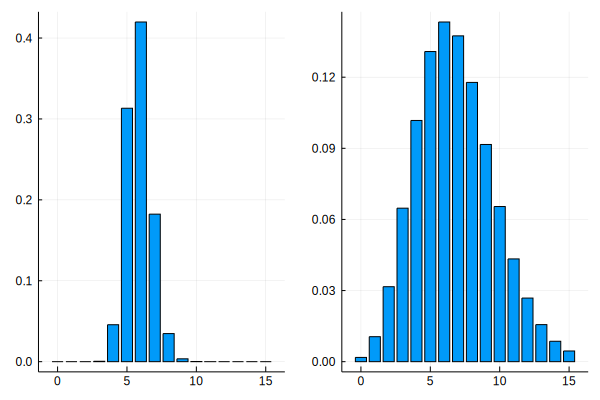

In [3]:
X = [sum(x[1:i]) for i in 1:n]

alpha(t) = X[Int(t)]
theta(t) = 1/(t+1)

# Posterior distribution of λ
posterior(t) = Gamma(alpha(t), theta(t))

# Predictive posterior of next sample
predictive(t) = NegativeBinomial(alpha(t), 1-theta(t))

T=Int(n*0.1) # observed % of test data
plot(0:1:15, [x -> Distributions.pdf(posterior(T), x), x -> Distributions.pdf(predictive(T), x)], seriestype=:bar, layout=2, leg=:none)

See how the posterior distribution behaves over time and settles close to the known value.

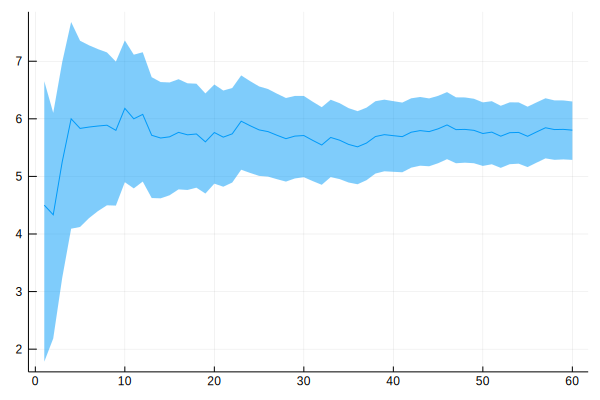

In [4]:
λes = [mean(posterior(i)) for i in 1:n]
λlower = [quantile(posterior(i), 0.05)-λes[i] for i in 1:n]
λupper = [λes[i]-quantile(posterior(i), 0.95) for i in 1:n]
plot(λes, ribbon=(λlower, λupper), leg=:none)

Construct a whole ensemble of trajectories to use as a background guide.

In [5]:
ensemble = []
for j in 1:1000
samples = Array{Real}(undef, n)
for i in 1:n
    samples[i] = 12*rand() + ((i>1) ? samples[i-1] : 0)
end
push!(ensemble, samples)
end

We want to throttle the total to a specific value by only allowing a fraction of the samples through. To do that we can calculate the overshoot factor with the data up to the current time, t, and aapply it as a correcting factor to the samples.

In [6]:
T = 300 # Desired total samples allowed through
y = []
for t in 1:n
    λest = quantile(posterior(t), 0.9)
    S = sum(x[1:t]) + (n-t)*λest # Estimated total
    factor = minimum([1.0, T/S])
    push!(y, x[t]*factor)
end

Evolve the posterior distribution over time and see how the it narrows to the actual values. Display with the ensemble and the trottles samples.

┌ Info: Saved animation to 
│   fn = /Users/john/Projects/personal/notebooks/tmp.gif
└ @ Plots /Users/john/.julia/packages/Plots/WwFyB/src/animation.jl:98


Plots.AnimatedGif("/Users/john/Projects/personal/notebooks/tmp.gif")
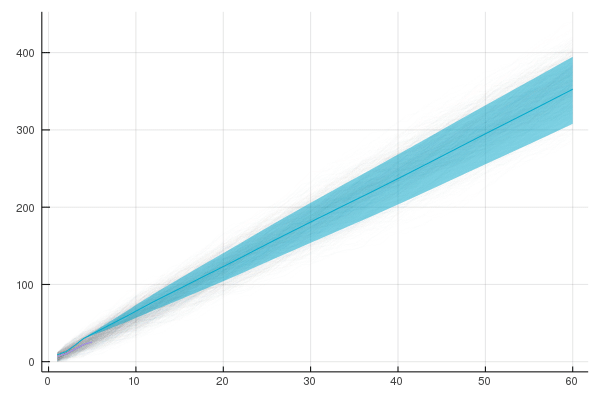

In [7]:
Xpred = Array{Real}(undef, n)
lower = Array{Real}(undef, n)
upper = Array{Real}(undef, n)
@gif for t in 5:n  
    for i in 1:n
        Xpred[i] = i<t ? X[i] : Xpred[i-1] + λes[i]
        lower[i] = i<t ? 0 : lower[i-1] + λlower[i]
        upper[i] = i<t ? 0 : upper[i-1] + λupper[i]
    end

    plot(ensemble, alpha=0.01)
    plot!(Xpred, ribbon=(lower, upper))
    plot!([sum(y[1:i]) for i in 1:t])
end